In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
from probesLocation import probesLocation

In [2]:
def getProbeCountry(probeId):  # pegar país
    return probesLocation.get(probeId, {}).get('país', f'ID {probeId} não encontrado')

def getProbeContinent(probeId):  # pegar continente
    return probesLocation.get(probeId, {}).get('continente', f'ID {probeId} não encontrado')

def getLatency(probeInfo):
    latencias = []
    for hop in probeInfo['result']:
        latenciasHop = [item['rtt'] for item in hop['result'] if 'rtt' in item]
        latencias.append(latenciasHop)
    return latencias

In [3]:
pais = []
cod = []

In [4]:
pais = []
cod = []
probeGroupedInfo = {}

with open('jsonFiles/GoogleNews.json', 'r') as jsonFile:
    resultInfo = json.load(jsonFile)
for probeInfo in resultInfo['info']:
    if probeInfo["destination_ip_responded"]:  # Verifica se a probe chegou ao destino
        probeJson = {
            'probeId': probeInfo['prb_id'],
            'destino': probeInfo['dst_name'],
            'pais': getProbeCountry(probeInfo['prb_id']),
            'continente': getProbeContinent(probeInfo['prb_id']),
            'latencia': getLatency(probeInfo),
            'quantidadeSaltos': len(probeInfo['result']),
            'data': datetime.fromtimestamp(probeInfo['stored_timestamp']).strftime('%Y-%m-%d %H:%M:%S')
        }
        
        if probeJson['probeId'] in probeGroupedInfo:
            probeGroupedInfo[probeJson['probeId']].append(probeJson['pais'])
        else:
            probeGroupedInfo[probeJson['probeId']] = [probeJson['pais']]

for x in probeGroupedInfo:
    if x not in cod:
        cod.append(x)
        pais.append(probeGroupedInfo[x][0])
pais = list(set(pais))

In [12]:
probeGroupedInfo = {}
with open('jsonFiles/GoogleNews.json', 'r') as jsonFile:
    resultInfo = json.load(jsonFile)
for probeInfo in resultInfo['info']:
    if probeInfo["destination_ip_responded"] and getProbeCountry(probeInfo['prb_id']) == pais[2]: # id do pais que voce quer as probes
        probeJson = {
            'probeId': probeInfo['prb_id'],
            'destino': probeInfo['dst_name'],
            'pais': getProbeCountry(probeInfo['prb_id']),
            'continente': getProbeContinent(probeInfo['prb_id']),
            'latencia': getLatency(probeInfo),
            'quantidadeSaltos': len(probeInfo['result']),
            'data': datetime.fromtimestamp(probeInfo['stored_timestamp']).strftime('%Y-%m-%d %H:%M:%S')
        }
        
        if probeJson['probeId'] in probeGroupedInfo:
            probeGroupedInfo[probeJson['probeId']].append(probeJson)
        else:
            probeGroupedInfo[probeJson['probeId']] = [probeJson]
ids = [x for x in probeGroupedInfo]

/tmp/ipykernel_36994/2988026355.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='timestamp', y='rtt', hue='destination', marker='o', ci=None)


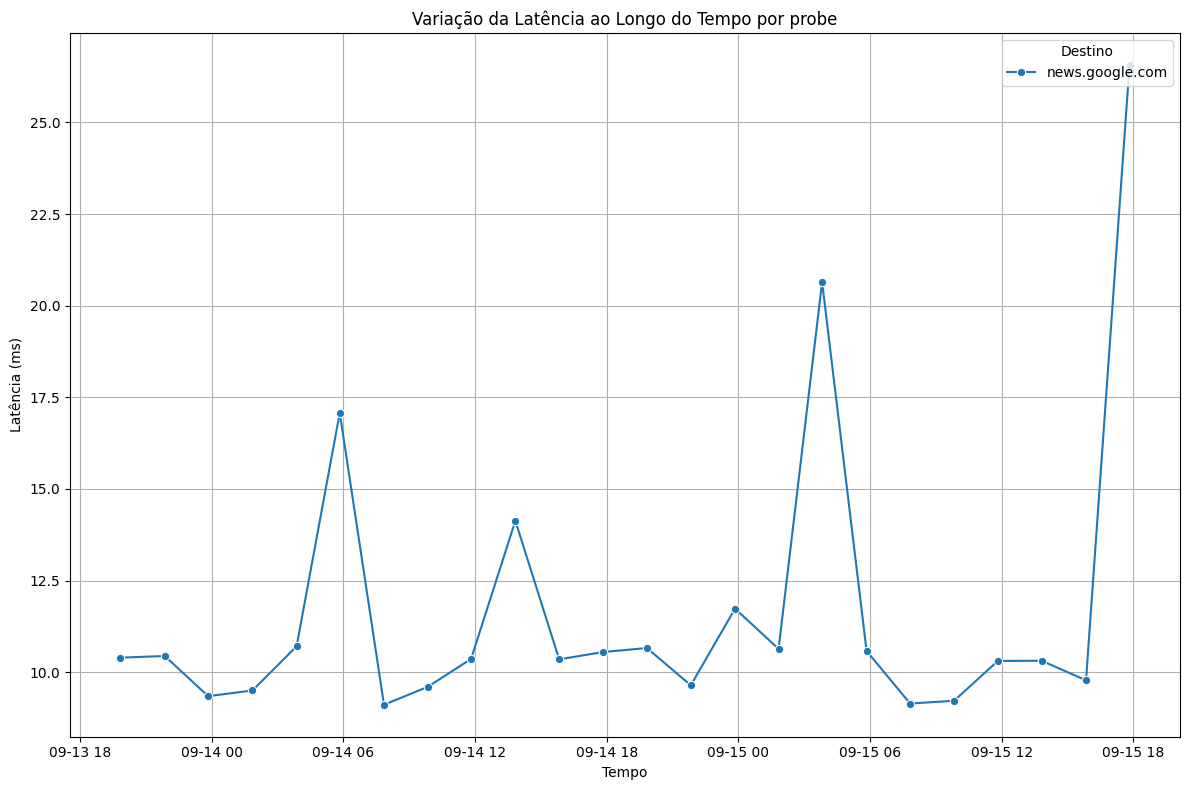

In [32]:
data = probeGroupedInfo[ids[0]] # de 0 a 3 qual probe por pais voce quer

rows = []

# Iterar sobre cada medição
for measurement in data:
    probe_id = measurement['probeId']
    destination = measurement['destino']
    country = measurement['pais']
    continent = measurement['continente']
    timestamp = measurement['data']
    
    for hop_num, hop_latencies in enumerate(measurement['latencia'], start=1):
        # Ignorar saltos vazios
        if hop_latencies:
            for rtt in hop_latencies:
                rows.append({
                    'probe_id': probe_id,
                    'destination': destination,
                    'country': country,
                    'continent': continent,
                    'timestamp': timestamp,
                    'hop': hop_num,
                    'rtt': rtt
                })

# Criar o DataFrame
df = pd.DataFrame(rows)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Plotar a variação da latência ao longo do tempo por destino
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='timestamp', y='rtt', hue='destination', marker='o', ci=None)
plt.title('Variação da Latência ao Longo do Tempo por probe')
plt.xlabel('Tempo')
plt.ylabel('Latência (ms)')
plt.legend(title='Destino', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


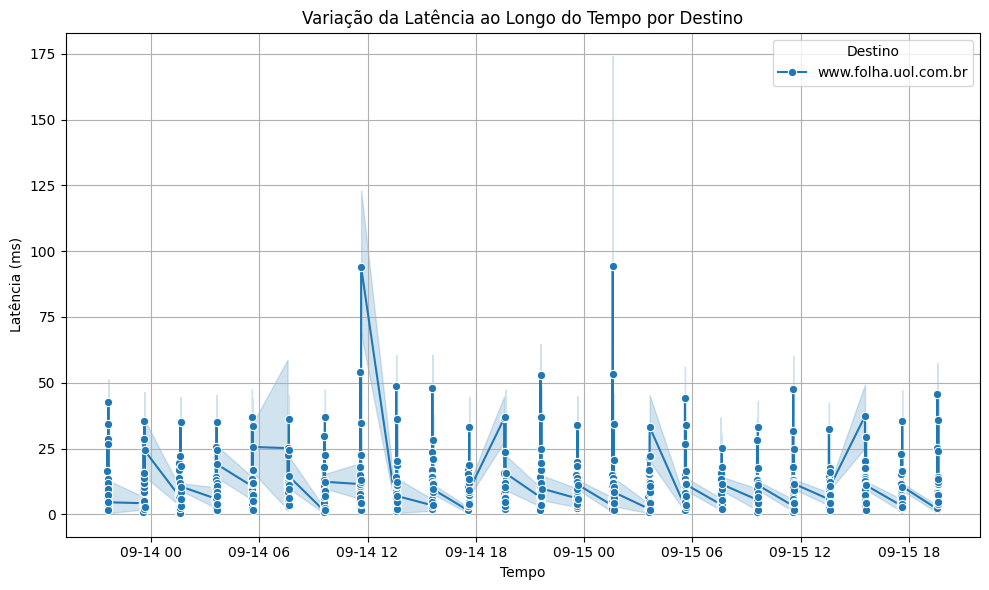

In [7]:
with open('jsonFiles/FolhaSP.json', 'r') as f:
    data = json.load(f)

rows = []
for measurement in data['info']:
    destination = measurement['dst_name']
    timestamp = measurement['endtime']
    for hop in measurement['result']:
        hop_num = hop['hop']
        for result in hop['result']:
            if 'rtt' in result:
                rows.append({
                    'destination': destination,
                    'timestamp': timestamp,
                    'hop': hop_num,
                    'rtt': result['rtt']
                })

df = pd.DataFrame(rows)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='timestamp', y='rtt', hue='destination', marker='o')
plt.title('Variação da Latência ao Longo do Tempo por Destino')
plt.xlabel('Tempo')
plt.ylabel('Latência (ms)')
plt.legend(title='Destino', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


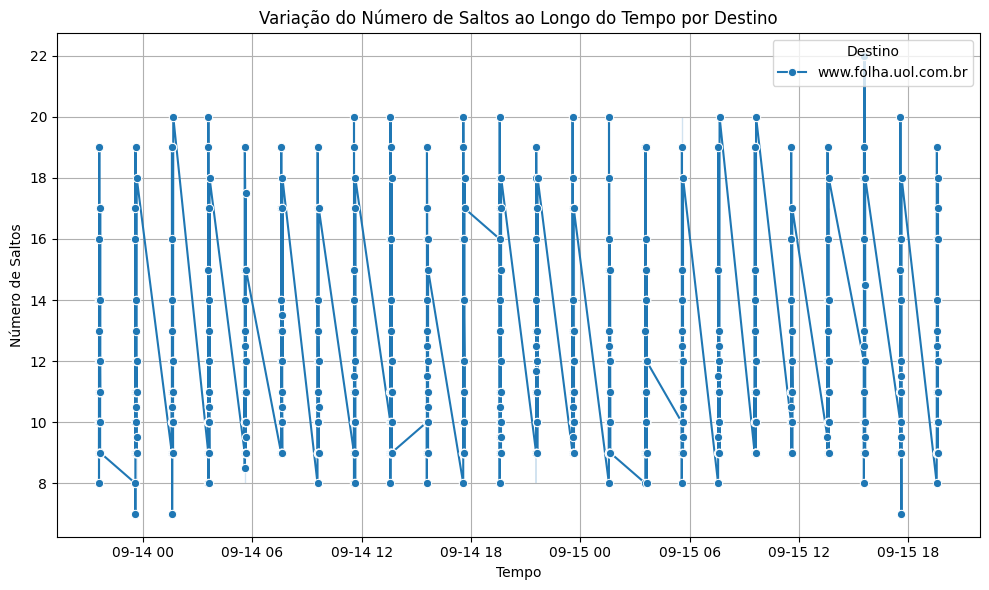

In [9]:
hop_data = []
for measurement in data['info']:
    destination = measurement['dst_name']
    timestamp = measurement['endtime']
    hop_count = len([hop for hop in measurement['result'] if 'result' in hop])
    hop_data.append({
        'destination': destination,
        'timestamp': timestamp,
        'hops': hop_count
    })

hop_df = pd.DataFrame(hop_data)
hop_df['timestamp'] = pd.to_datetime(hop_df['timestamp'], unit='s')

plt.figure(figsize=(10, 6))
sns.lineplot(data=hop_df, x='timestamp', y='hops', hue='destination', marker='o')
plt.title('Variação do Número de Saltos ao Longo do Tempo por Destino')
plt.xlabel('Tempo')
plt.ylabel('Número de Saltos')
plt.legend(title='Destino', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


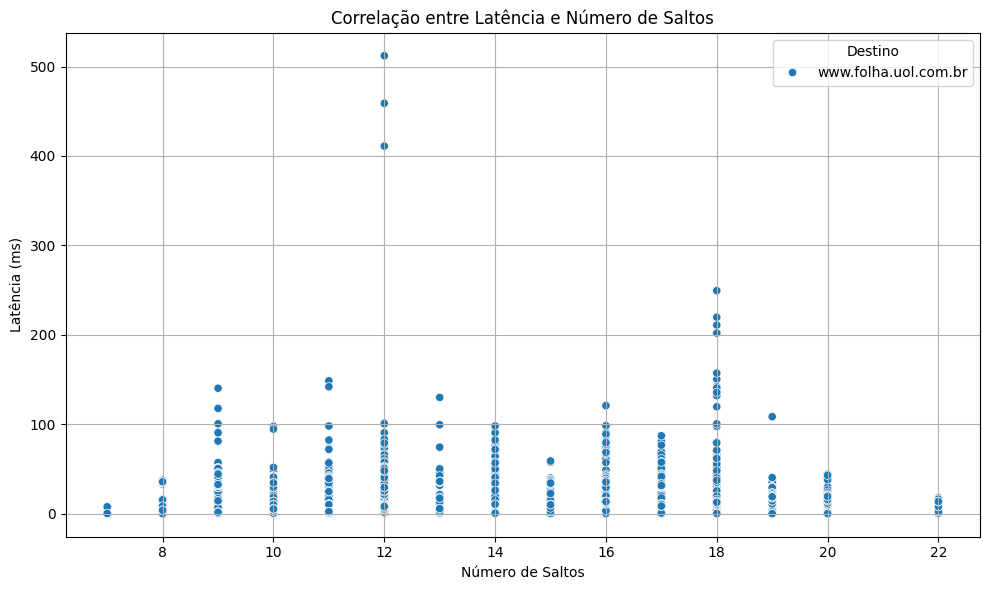

In [10]:
merged_df = pd.merge(df, hop_df, on=['destination', 'timestamp'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='hops', y='rtt', hue='destination')
plt.title('Correlação entre Latência e Número de Saltos')
plt.xlabel('Número de Saltos')
plt.ylabel('Latência (ms)')
plt.legend(title='Destino', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
